In [1]:
%matplotlib inline
from CartPole import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

# Task 2

In [2]:
plot_path = 'plots/Task2/'
index_to_variable = {0 : 'cart_location', 1 : 'cart_velocity', 2 : 'pole_angle', 3 : 'pole_velocity', 4 : 'action'}
index_pair_list = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3],[0,4],[1,4],[2,4],[3,4]]
no_samples = 20
x_range_for_index = {0 : np.linspace(-5,5,no_samples), 1 : np.linspace(-10,10,no_samples), 
                     2 : np.linspace(-np.pi,np.pi,no_samples), 3 : np.linspace(-15,15,no_samples), 
                     4 : np.linspace(-20,20,no_samples)}

lam = 0.00001
n = 2000
no_RBC = 320
train_proportion = 0.8

## plot convergence of model for varying no. basis functions

C:\Users\Jordan\Anaconda3\lib\site-packages\autograd\tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)
C:\Users\Jordan\Anaconda3\lib\site-packages\autograd\tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)
C:\Users\Jordan\Anaconda3\lib\site-packages\autograd\tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future defau

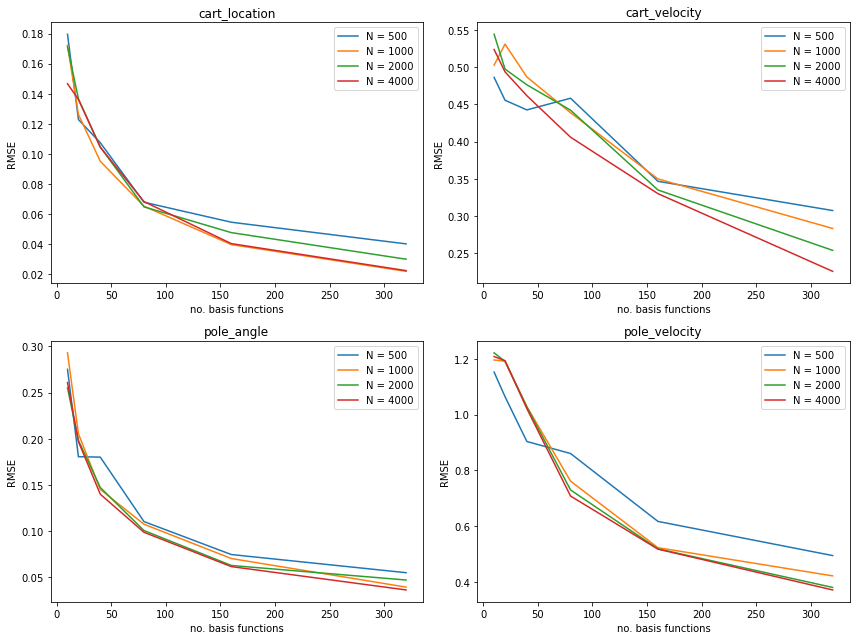

In [3]:
i_range = [10, 20, 40, 80, 160, 320] # list of no. radial basis functions to try
n_range = [500, 1000, 2000, 4000] # list of sizes of dataset to try

fig,axs = plt.subplots(2,2,figsize=(12,9))
for n in n_range:
    x_train, y_train, x_test, y_test = generate_data(n)
    sigma = np.std(x_train, axis=0)
    
    RMSE = None
    
    for i in i_range:
        alpha, X_i_vals = train_alpha(x_train, y_train, i, sigma, n, train_proportion)
        predictions = predict(x_test, alpha, X_i_vals, sigma)
        RMSE_ = np.array(display_RMSE(predictions, y_test))
        
        try:
            RMSE = np.vstack((RMSE, RMSE_))
        except:
            RMSE = RMSE_
    for j in range(4):
        axs[int(round((j+1)/4,0)),j%2].plot(i_range, RMSE[:,j], label='N = {}'.format(str(n)))
        axs[int(round((j+1)/4,0)),j%2].legend()
        axs[int(round((j+1)/4,0)),j%2].set_title(index_to_variable[j])
        axs[int(round((j+1)/4,0)),j%2].set_xlabel('no. basis functions')
        axs[int(round((j+1)/4,0)),j%2].set_ylabel('RMSE')
fig.tight_layout()
# plt.savefig(plot_path + 'convergence_of_non_linear_model')

## Plot model predictions vs actual values

In [4]:
x_train, y_train, x_test, y_test = generate_data(n)
sigma = np.std(x_train, axis=0)

alpha, X_i_vals = train_alpha(x_train, y_train, no_RBC, sigma, n, train_proportion)
predictions = predict(x_test, alpha, X_i_vals, sigma)

C:\Users\Jordan\Anaconda3\lib\site-packages\autograd\tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)


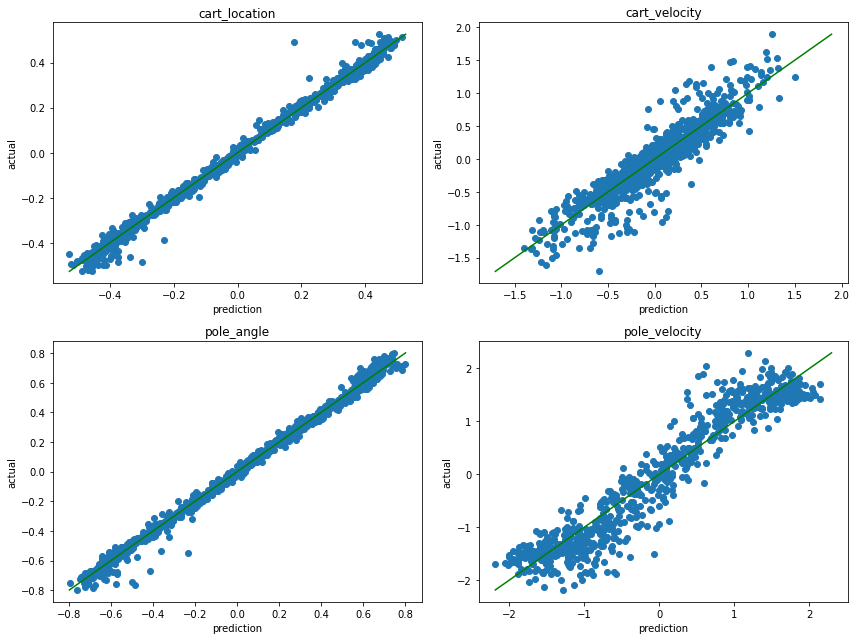

In [5]:
fig,axs = plt.subplots(2,2,figsize=(12,9))
for j in range(4):
    ul = max(max(predictions[:,j]), max(y_test[:,j]))
    ll = min(min(predictions[:,j]), min(y_test[:,j]))
    axs[int(round((j+1)/4,0)),j%2].scatter(predictions[:,j], y_test[:,j])
    axs[int(round((j+1)/4,0)),j%2].plot([ll,ul],[ll,ul], color='g')
    axs[int(round((j+1)/4,0)),j%2].set_title(index_to_variable[j])
    axs[int(round((j+1)/4,0)),j%2].set_xlabel('prediction')
    axs[int(round((j+1)/4,0)),j%2].set_ylabel('actual')
    
    fig.tight_layout()
    
# plt.savefig(plot_path + 'prediction_accuracy_with_action')

## Plot contours for non linear model

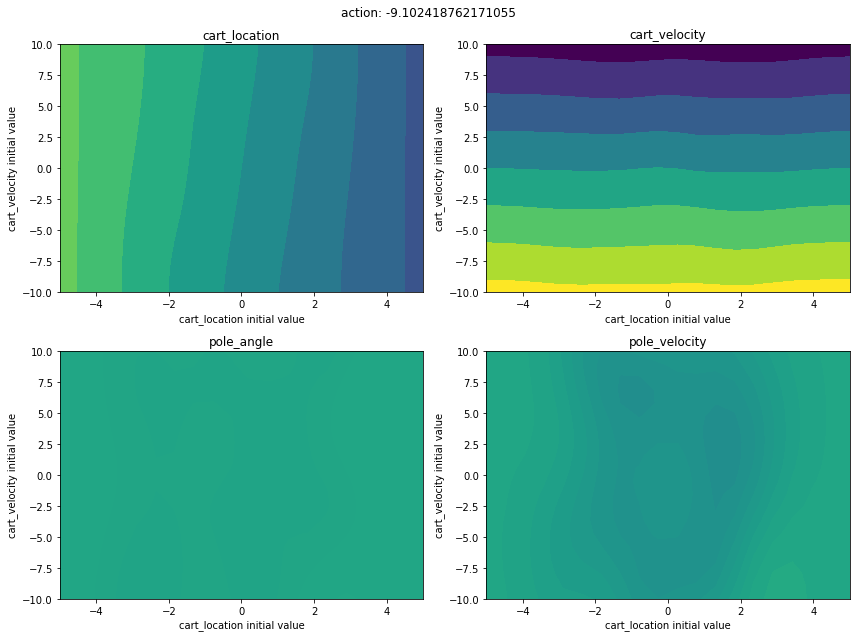

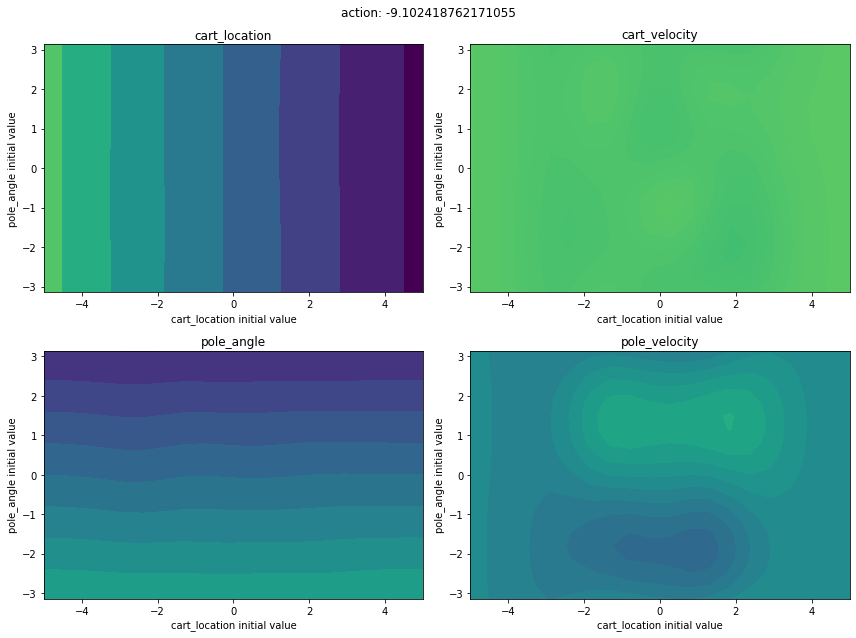

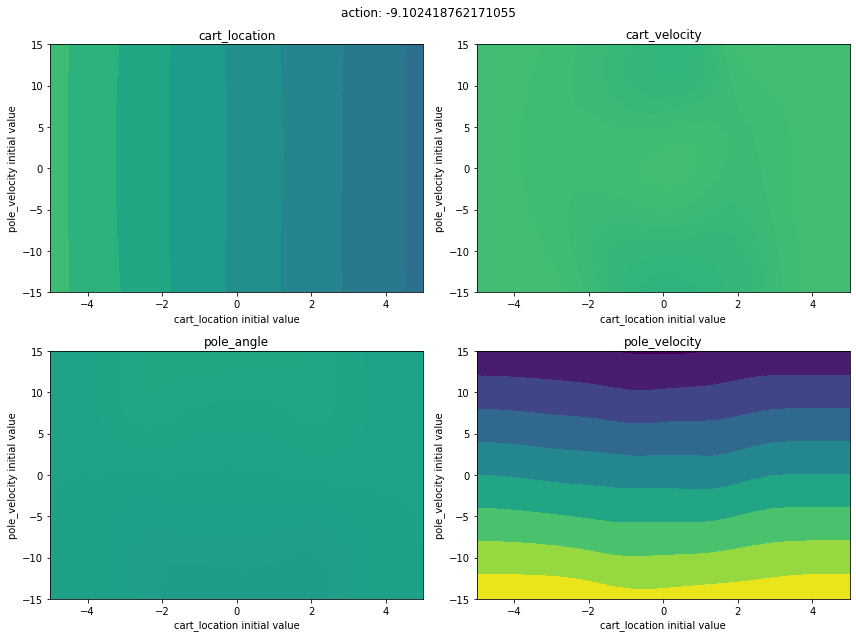

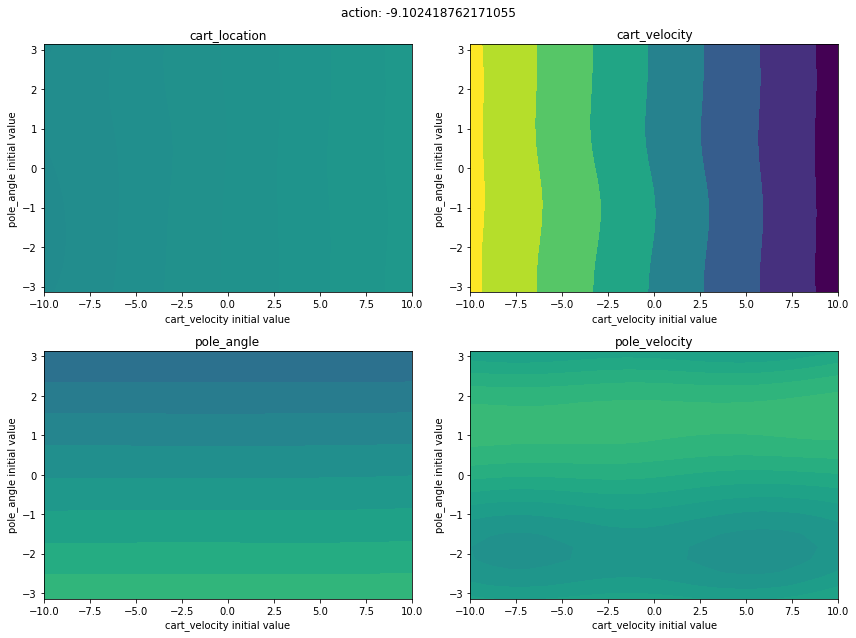

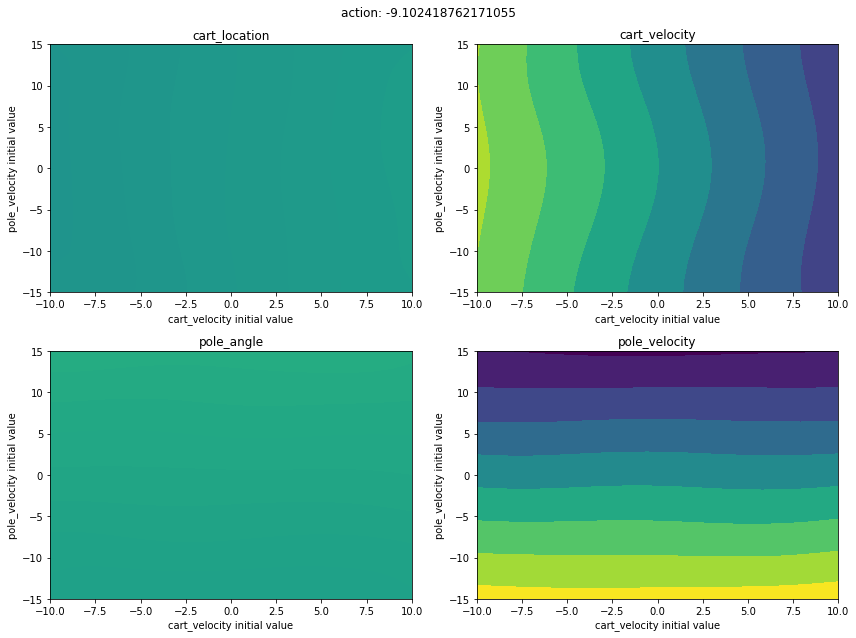

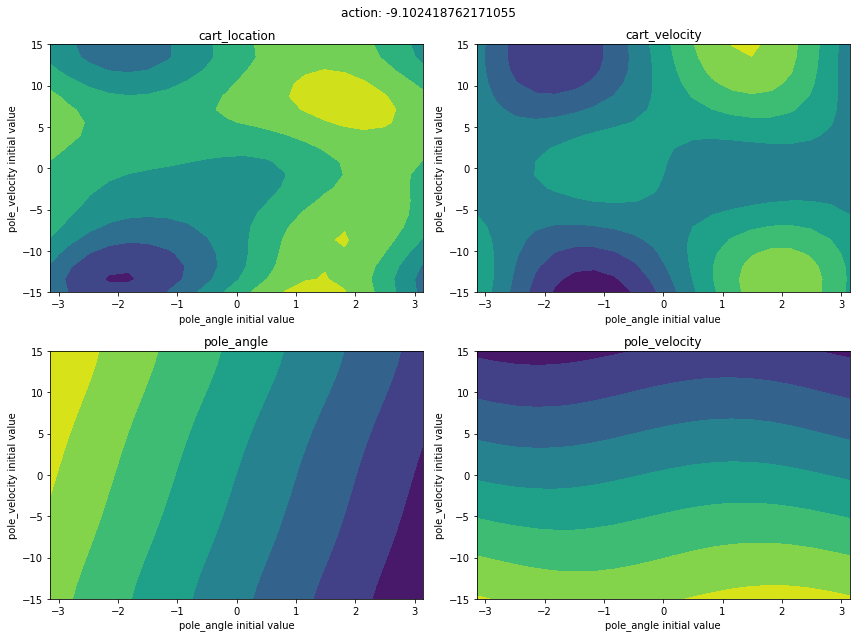

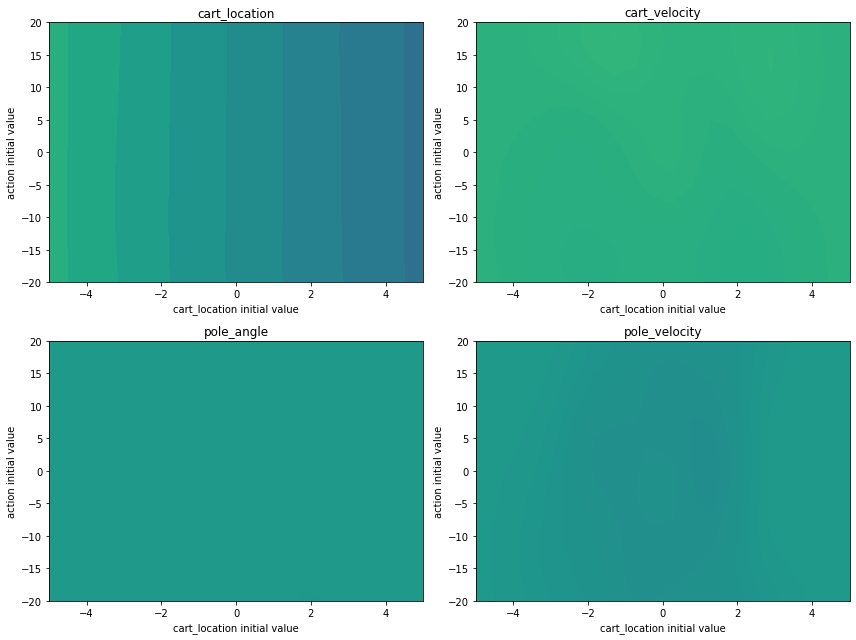

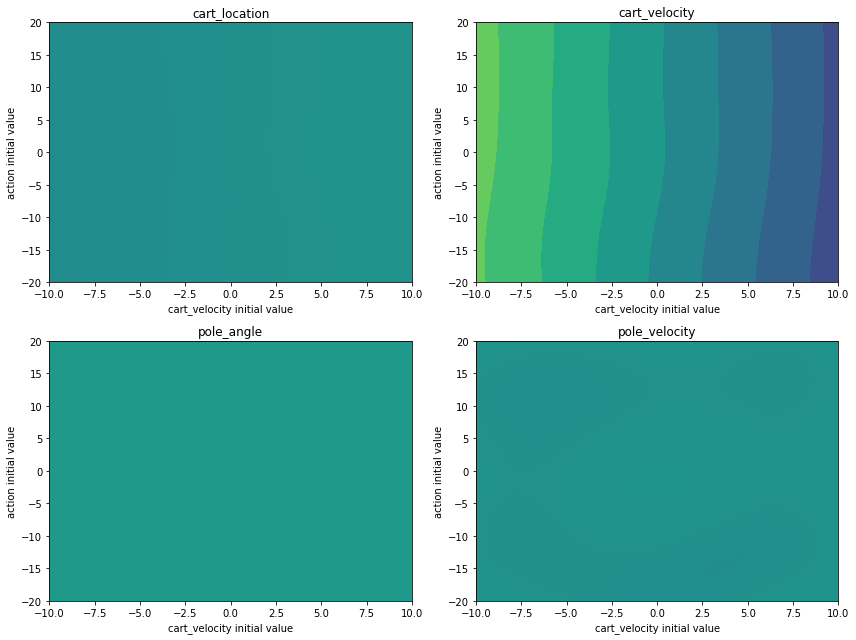

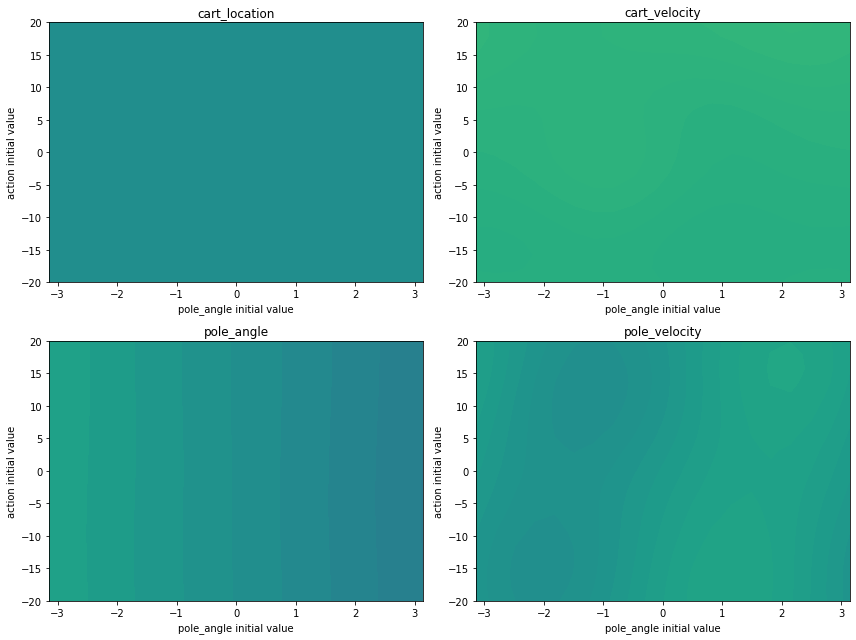

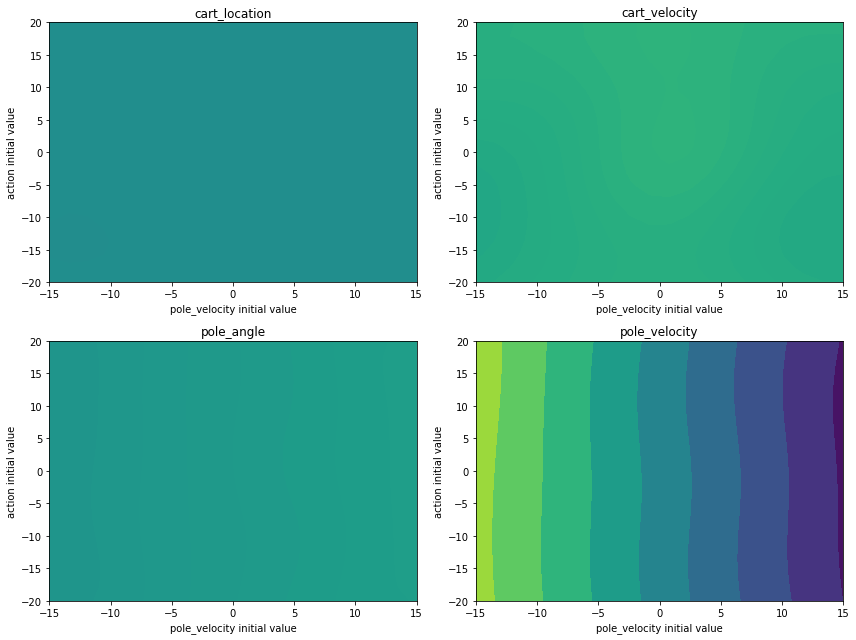

In [6]:
for index_pair in index_pair_list:
    plot_y_contour_as_difference_in_x(x_test[0], index_pair, range_x_pair_finder(index_pair, x_range_for_index), 
                                      index_to_variable, dynamics='predicted', model=predict, alpha=alpha, 
                                      X_i_vals=X_i_vals, sigma=sigma)
#     plt.savefig(plot_path+'contour_plot_predictions_with_action'+str(index_pair))
#     plt.close()

## Testing different values of lambda

action in project_x_using_model step 0 was 10.809643662738154
action in project_x_using_model step 1 was 10.809643662738154
action in project_x_using_model step 2 was 10.809643662738154
action in project_x_using_model step 3 was 10.809643662738154
action in project_x_using_model step 4 was 10.809643662738154
action in project_x_using_model step 5 was 10.809643662738154
action in project_x_using_model step 6 was 10.809643662738154
action in project_x_using_model step 7 was 10.809643662738154
action in project_x_using_model step 8 was 10.809643662738154
action in project_x_using_model step 9 was 10.809643662738154
action in project_x_using_model step 0 was 10.809643662738154
action in project_x_using_model step 1 was 10.809643662738154
action in project_x_using_model step 2 was 10.809643662738154
action in project_x_using_model step 3 was 10.809643662738154
action in project_x_using_model step 4 was 10.809643662738154
action in project_x_using_model step 5 was 10.809643662738154
action i

Text(0.5, 1.0, 'RMSE error for different values of lambda')

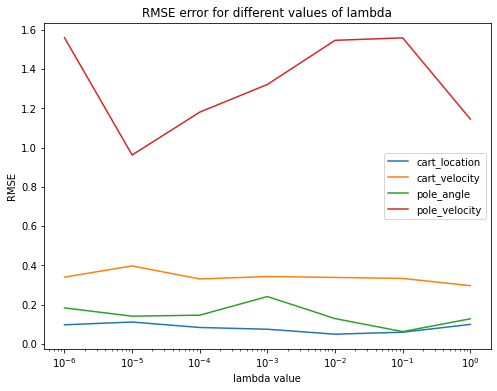

In [7]:
n = 500
x_train, y_train, x_test, y_test = generate_data(n)
sigma = np.std(x_train, axis=0)
initial_x = x_test[0]

RMSE_data = []
for lam in [0.1**i for i in range(7)]:
    alpha, X_i_vals = train_alpha(x_train, y_train, 40, sigma, n, train_proportion, lam=lam)

    prediction_history, y_history = project_x_using_model(x_test[0], predict, steps=10, remap_angle=False, alpha=alpha, 
                                                           X_i_vals=X_i_vals, sigma=sigma)
    RMSE_data.append(display_RMSE(prediction_history, y_history))
    
RMSE_data = np.array(RMSE_data)

fig,ax = plt.subplots(1,1,figsize=(8,6))
for j in range(4):
    ax.plot([0.1**i for i in range(7)], RMSE_data[:,j], label=index_to_variable[j])
ax.legend()
ax.set_xscale('log')
ax.set_xlabel('lambda value')
ax.set_ylabel('RMSE')
ax.set_title('RMSE error for different values of lambda')
# plt.savefig(plot_path + 'RMSE_different_lambda')

## Rollout with model prediction

[ 0.84309353 -7.71036848  1.30949281  5.96235836]


C:\Users\Jordan\Anaconda3\lib\site-packages\autograd\tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)


action in project_x_using_model step 0 was 10.809643662738154
action in project_x_using_model step 1 was 10.809643662738154
action in project_x_using_model step 2 was 10.809643662738154
action in project_x_using_model step 3 was 10.809643662738154
action in project_x_using_model step 4 was 10.809643662738154
action in project_x_using_model step 5 was 10.809643662738154
action in project_x_using_model step 6 was 10.809643662738154
action in project_x_using_model step 7 was 10.809643662738154
action in project_x_using_model step 8 was 10.809643662738154
action in project_x_using_model step 9 was 10.809643662738154


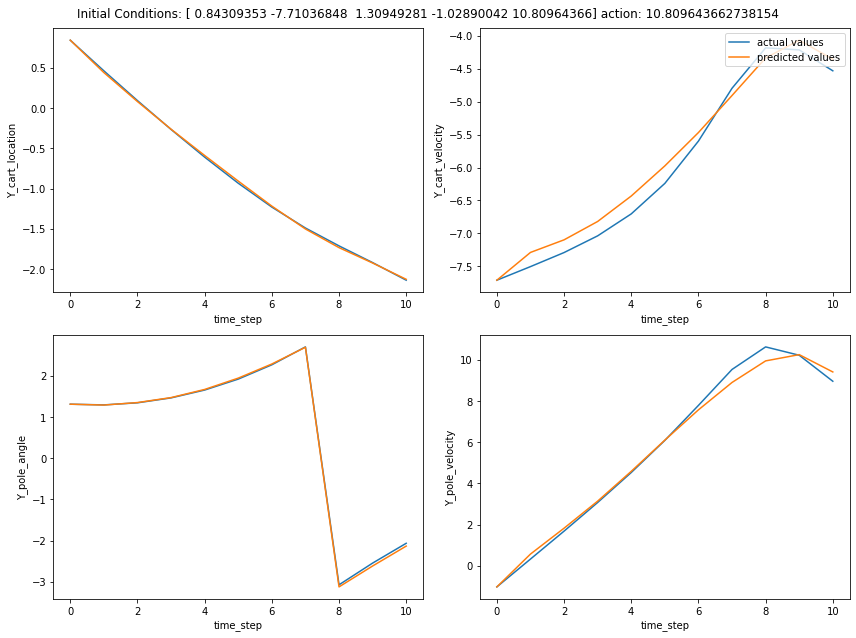

In [8]:
steps = 10

oscillating_initial_condition = np.array([x_test[0][i] if i != 3 else np.random.uniform(5,10) for i in range(4)])
print(oscillating_initial_condition)

sigma = np.std(x_train, axis=0)
alpha, X_i_vals = train_alpha(x_train, y_train, no_RBC, sigma, n, train_proportion)

prediction_history, y_history = project_x_using_model(x_test[0], predict, steps=steps, remap_angle=False, 
                                                      compound_predictions=False, alpha=alpha, 
                                                      X_i_vals=X_i_vals, sigma=sigma)

prediction_history[:,2] = np.array([remap_angle(angle) for angle in prediction_history[:,2]])
y_history[:,2] = np.array([remap_angle(angle) for angle in y_history[:,2]])

plot_prediction_vs_actual_over_time(prediction_history, y_history, title='Initial Conditions: {}'.format(x_test[0]))
# plt.savefig(plot_path + 'model_rollout_prediction_with_action_{}_steps'.format(steps))

## Model performance scanning over 1 variable

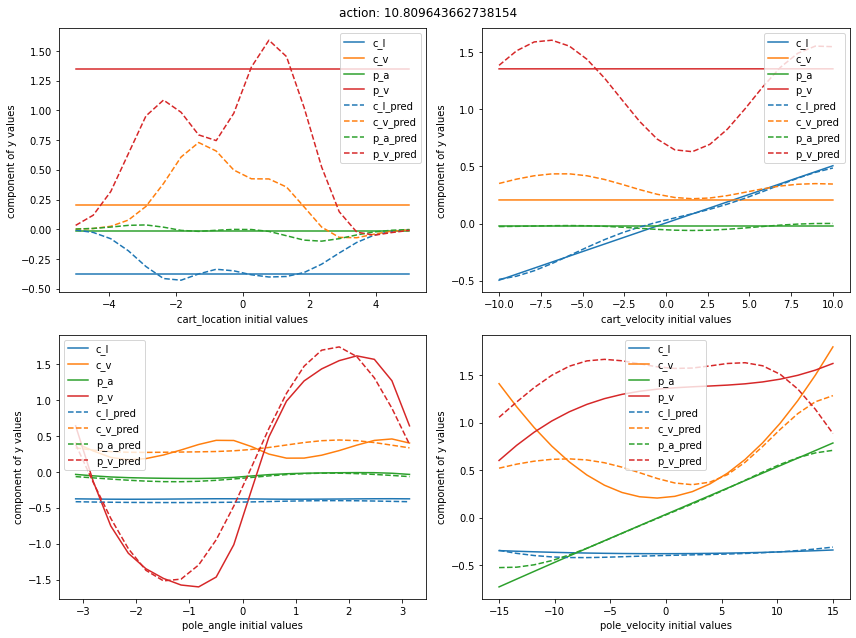

In [9]:
plot_y_scans(x_test[0], index_to_variable, x_range_for_index, predict, alpha=alpha, 
             X_i_vals=X_i_vals, sigma=sigma)
# plt.savefig(plot_path + 'model_accuracy_scan_over_1_variable_with_action')

## Introducing the loss function

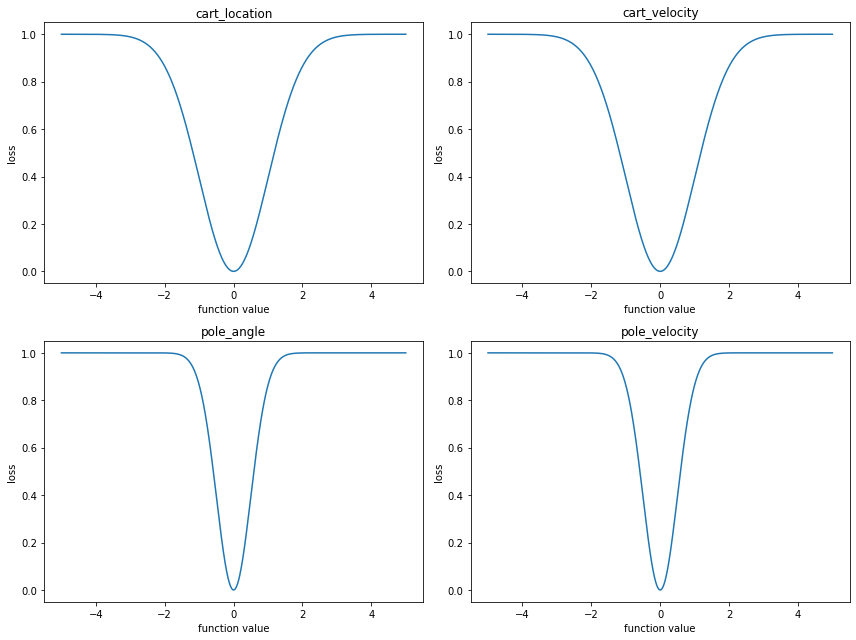

In [10]:
fig, axs = plt.subplots(2,2, figsize=(12,9))
total_loss = np.zeros(20)
for j in range(4):
    zer = [0,0,0,0]
    x_list = []
    for i in np.linspace(-5,5,1000):
        x_ = zer.copy()
        x_[j] = i
        x_list.append(x_)
        
    axs[int(round((j+1)/4,0)),j%2].plot(np.linspace(-5,5,1000), [loss(x_) for x_ in x_list])
    axs[int(round((j+1)/4,0)),j%2].set_xlabel('function value')
    axs[int(round((j+1)/4,0)),j%2].set_ylabel('loss')
    axs[int(round((j+1)/4,0)),j%2].set_title(index_to_variable[j])
#     total_loss += np.array([loss(x_) for x_ in x_list])
fig.tight_layout()
# plt.plot([i for i in np.linspace(0,2,20)], total_loss, label='sum of all loss')
# plt.legend()
# plt.savefig(plot_path + 'original_loss_function')

Text(0, 0.5, 'loss')

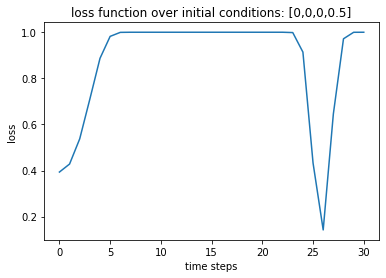

In [11]:
steps = 30
loss_history, y_history = project_loss([0,0,0,0.5,0.0], steps = steps)

plt.plot([i for i in range(steps+1)], loss_history)
plt.title('loss function over initial conditions: [0,0,0,0.5]')
plt.xlabel('time steps')
plt.ylabel('loss')
# plt.savefig(plot_path + 'new_loss_function_over_time')

0.8428174767383374


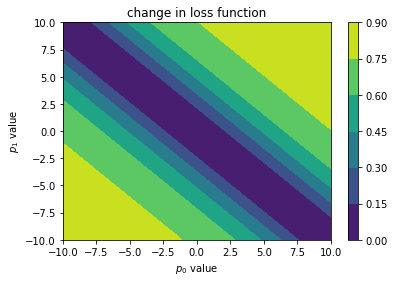

0.9155048181405041


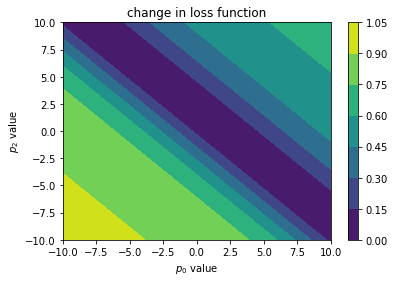

0.8704769968646182


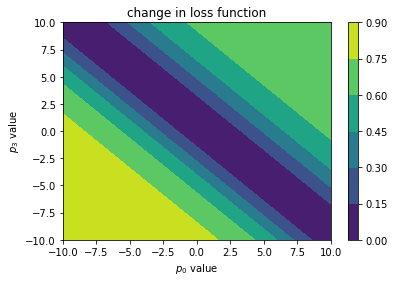

0.9117542452108348


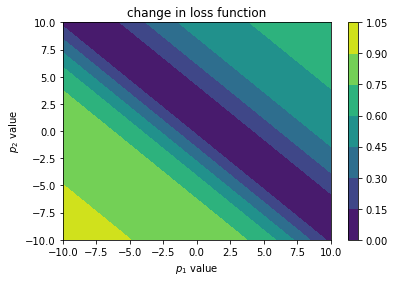

0.8641639806860265


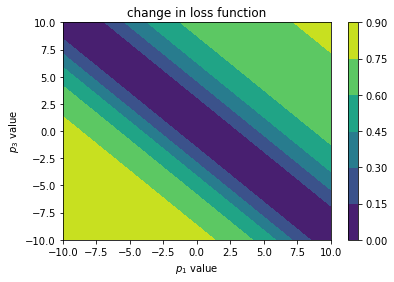

0.924439342996167


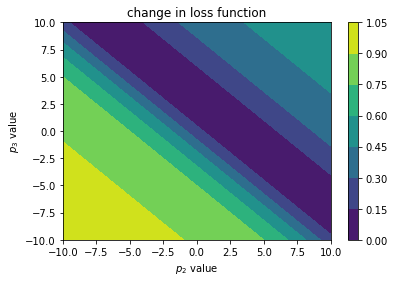

In [12]:
for index_pair in [index_pair for index_pair in index_pair_list if 4 not in index_pair ]:
    x_ = np.zeros(5)
    x_[index_pair] += 0.1
    plot_loss_contours(x_, [0,0,0,0], index_pair, [np.linspace(-10,10,10)]*2)
#     plt.savefig(plot_path + 'loss_contours_scanning_p_values')
    plt.show()


### Optimise the linear matrix P

In [13]:
linear_training_data = [0,0,0.01,0,0]
kwargs_ = {'parameter_to_be_optimised':'p', 'linear':True, 'model_predictive_control':False,
          'sig_':[1,1,0.5,0.5]}

In [14]:
p_start = np.random.uniform(-1,1,4)
p = scipy.optimize.minimize(training_loss, p_start, 
                        args=(linear_training_data, kwargs_), 
                              options={'disp':True})['x']
p, p_start

[ 0.31582498 -0.04074553 -0.67978485  0.15614742]


KeyError: 'sig'

for initial_x values any larger than roughly 0.5, the function converges on a local minimum of [0,0,0,0].

for initial_x values in the range -0.5, 0.5, the function converges on suitable values of p.

Values found independent of start points, unless start points are outside the range -1 to 1

## Train loss sig values using linear model

In [15]:
linear_training_data = np.random.normal(0,0.2,(10,5))
kwargs_ = {'parameter_to_be_optimised':'loss_sig_value', 'linear':True, 
           'model_predictive_control':False, 
           'p':np.array([-0.06139608, -0.03320714,  1.96606844,  0.29200164]),
          'alpha':[1,1,0.5,0.5]}

loss_sig_start = np.array([0.5,0.5,0.5,0.5])
loss_sig = scipy.optimize.minimize(training_loss, loss_sig_start, 
                        args=(linear_training_data, kwargs_))['x']
loss_sig, loss_sig_start

[0.5 0.5 0.5 0.5]


KeyError: 'sig'

In [16]:
loss_sig = np.array([ 56.56369296,  94.61970037,  82.14352495, 111.14785428])

## Control against real dynamics

In [17]:
steps = 30
print('p:', p)

x_ = [0,0,.01,0,0]
uc_ = x_.copy()
x_history = [x_.copy()]
uncontrolled_history = [uc_.copy()]
color_list = ['C{}--'.format(i) for i in range(4)]

for step in range(steps):
    action_ = 20 * np.tanh(np.dot(p, x_[:-1])/20)
    x_[-1] = action_
    x_ = np.array(move_cart(x_, steps=1, display_plots=False, remap_angle=True))
    uc_ = np.array(move_cart(uc_, steps=1, display_plots=False, remap_angle=True)) 
    x_history.append(x_)
    uncontrolled_history.append(uc_)
    
x_history = np.array(x_history)
uncontrolled_history = np.array(uncontrolled_history)

fig, ax = plt.subplots(1, 1, figsize=(8,6))

for i in [0,1,2,3]:
    ax.plot([i for i in range(steps+1)], [x[i] for x in x_history], label=index_to_variable[i])
#     ax.plot([i for i in range(steps+1)], [uc[i] for uc in uncontrolled_history], color_list[i], 
#             label='uncontrolled {}'.format(index_to_variable[i]))
# ax.set_ylim(-3,3)
ax.set_title('linear control stabilising pole initial_conditions: {}'.format(np.round(x_history[0][:-1],3)))
ax.legend()
fig.tight_layout()
# plt.savefig(plot_path + 'linear_control_pole_stabilising_real_dynamics_rollout')

NameError: name 'p' is not defined

clealy this linear policy is quite effective over a small number of steps and for a very small initial condition

## Control against predicted dynamics (non linear model)

In [18]:
steps = 10
print('p:', p)

x_ = [0,0,0.01,0,0]
x_history = [x_.copy()]
action_ = 20 * np.tanh(np.dot(p, x_[:-1]))

for step in range(steps):
    action_ = 20 * np.tanh(np.dot(p, x_[:-1]))
    x_[-1] = action_
    x_ = predict(np.array(x_), alpha, X_i_vals, sigma)[0].tolist()
    x_history.append(x_)
    
x_history = np.array(x_history)

fig, ax = plt.subplots(1, 1)

for i in [0,1,2,3]:
    ax.plot([i for i in range(steps+1)], [x[i] for x in x_history], label=index_to_variable[i])
ax.set_title('linear control stabilising pole initial_conditions: {}'.format(np.round(x_history[0][:-1],3)))
ax.legend()
fig.tight_layout()
# plt.savefig(plot_path + 'linear_control_pole_stabilising_model_predictions_rollout')

NameError: name 'p' is not defined

## Task 2.4
### Model Predictive Control

In [19]:
linear_training_data = np.array([0,0,0.01,0,0])
rollout_prediction_model_attr = {'alpha':alpha, 'X_i_vals':X_i_vals, 'sigma':sigma}
kwargs_ = {'parameter_to_be_optimised':'p', 'linear':True, 'model_predictive_control':True,
          'rollout_prediction_model':predict, 'rollout_prediction_model_attr':rollout_prediction_model_attr,
          'alpha':[1,1,0.5,0.5], 'sig':[1,1,0.5,0.5]}

In [20]:
p_mpc = scipy.optimize.minimize(training_loss, 
                        np.random.randint(0,1,4), 
                        args=(linear_training_data, kwargs_))['x']
p_mpc

[0. 0. 0. 0.]
cumulative_loss: 	 43.2881
43.28814236328608
[1.49011612e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00]
cumulative_loss: 	 43.2881
43.288142365718514
[0.00000000e+00 1.49011612e-08 0.00000000e+00 0.00000000e+00]
cumulative_loss: 	 43.2881
43.28814270064292
[0.00000000e+00 0.00000000e+00 1.49011612e-08 0.00000000e+00]
cumulative_loss: 	 43.2881
43.28814242832409
[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.49011612e-08]
cumulative_loss: 	 43.2881
43.28814325027026
[-0.00258279 -0.35821013 -0.06905826 -0.94181197]
cumulative_loss: 	 92.1902
92.19021004313737
[-0.00258278 -0.35821013 -0.06905826 -0.94181197]
cumulative_loss: 	 92.1902
92.19021003326054
[-0.00258279 -0.35821011 -0.06905826 -0.94181197]
cumulative_loss: 	 92.1902
92.1902100068976
[-0.00258279 -0.35821013 -0.06905824 -0.94181197]
cumulative_loss: 	 92.1902
92.19021002887344
[-0.00258279 -0.35821013 -0.06905826 -0.94181196]
cumulative_loss: 	 92.1902
92.19020985154725
[-0.00035977 -0.04989724 -0.00961954 -

cumulative_loss: 	 12.9014
12.901415176575581
[ 0.07322512 -1.36099556  0.03369751 -0.19966235]
cumulative_loss: 	 12.9014
12.901415176602523
[ 0.07322512 -1.36099557  0.03369753 -0.19966235]
cumulative_loss: 	 12.9014
12.90141517657363
[ 0.07322512 -1.36099557  0.03369751 -0.19966234]
cumulative_loss: 	 12.9014
12.90141517657479
[ 0.07326442 -1.36105652  0.03396417 -0.19970259]
cumulative_loss: 	 12.9014
12.901415077487403
[ 0.07326443 -1.36105652  0.03396417 -0.19970259]
cumulative_loss: 	 12.9014
12.901415077487476
[ 0.07326442 -1.36105651  0.03396417 -0.19970259]
cumulative_loss: 	 12.9014
12.901415077488874
[ 0.07326442 -1.36105652  0.03396418 -0.19970259]
cumulative_loss: 	 12.9014
12.901415077483854
[ 0.07326442 -1.36105652  0.03396417 -0.19970257]
cumulative_loss: 	 12.9014
12.901415077484794
[ 0.07326319 -1.36111838  0.03449717 -0.19970819]
cumulative_loss: 	 12.9014
12.901414967293825
[ 0.0732632  -1.36111838  0.03449717 -0.19970819]
cumulative_loss: 	 12.9014
12.901414967293

cumulative_loss: 	 12.8907
12.890658172691923
[ 2.53806853 -5.10056439 61.50184737 -3.09950022]
cumulative_loss: 	 12.8907
12.890658169614767
[ 2.53806853 -5.10056439 61.50184736 -3.09950021]
cumulative_loss: 	 12.8907
12.89065816841106
[ 2.74178036 -5.47134494 67.44551134 -3.30506988]
cumulative_loss: 	 12.8862
12.88616864836581
[ 2.74178038 -5.47134494 67.44551134 -3.30506988]
cumulative_loss: 	 12.8862
12.886168648364345
[ 2.74178036 -5.47134492 67.44551134 -3.30506988]
cumulative_loss: 	 12.8862
12.886168649153145
[ 2.74178036 -5.47134494 67.44551136 -3.30506988]
cumulative_loss: 	 12.8862
12.886168648384706
[ 2.74178036 -5.47134494 67.44551134 -3.30506987]
cumulative_loss: 	 12.8862
12.886168647728443
[ 3.58472315 -6.87795473 90.29297091 -4.22123412]
cumulative_loss: 	 12.8853
12.885259912859322
[ 3.58472316 -6.87795473 90.29297091 -4.22123412]


KeyboardInterrupt: 

In [21]:
x_ = [0,0,0.01,0,0]
x_history = [x_.copy()]
steps = 15

for step in range(steps):
    action_ = np.dot(p_mpc, x_[:-1])
    x_[-1] = action_
    x_ = np.array(move_cart(x_, steps=1, display_plots=False, remap_angle=False))  
    x_history.append(x_)
    
x_history = np.array(x_history)

fig, ax = plt.subplots(1, 1)

for i in [0,1,2,3]:
    ax.plot([i for i in range(steps+1)], [x[i] for x in x_history], label=index_to_variable[i])
ax.set_title('linear control stabilising pole initial_conditions: {}'.format(np.round(x_history[0][:-1],3)))
ax.legend()
fig.tight_layout()
# plt.savefig(plot_path + 'model_predictive_control')

NameError: name 'p_mpc' is not defined